### Imports:

In [1]:
import ssl
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphic
import utils
import requests

### Settings:

In [2]:
%matplotlib inline
ssl._create_default_https_context = ssl._create_unverified_context
pd.set_option('display.max_columns', 40)
pd.set_option('display.precision', 4)

### Constants:

In [3]:
CURRENT_DIR = os.getcwd()

#### File names:

In [4]:
MENTAL_HEALTH_URL = "https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DPQ_I.XPT"
DRUG_USE_URL = "https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DUQ_I.XPT"
ALCOHOL_USE_URL = "https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/ALQ_I.XPT"
OCCUPATION_URL = "https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/OCQ_I.XPT"
SEXUAL_BEHAVIOUR_URL = "https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/SXQ_I.XPT"
DEMOGRAPHIC_URL = "https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.XPT"
INCOME_URL = "https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/INQ_I.XPT"
REPRODUCTIVE_URL = "https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/RHQ_I.XPT"

#### Columns:
<br>
<details>
  <summary>Column codes vocabulary</summary>
  
### Mental Health

#### NHANES Mental health variable dictionary:

This information is taken from [NHANES resourse](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/DPQ_H.htm)

| Survey code | Meaning | Value Description type |
| :--- | :--- | :---: |
| DPQ010 | Have little interest in doing things | 1 |
| DPQ020 | Feeling down, depressed, or hopeless | 1 |
| DPQ030 | Trouble sleeping or sleeping too much | 1 |
| DPQ040 | Feeling tired or having little energy | 1 |
| DPQ050 | Poor appetite or overeating | 1 |
| DPQ060 | Feeling bad about yourself | 1 |
| DPQ070 | Trouble concentrating on things | 1 |
| DPQ080 | Moving or speaking slowly or too fast | 1 |
| DPQ090 | Thought you would be better off dead | 1 |
| DPQ100 | How difficult have these problems made it for you to do your work, take care of things at home,<br> or get along with people? | 2 |

#### Value descriptions 
#### Value description type 1: 

 Value  Description 

0 – Not at all \
1 – Several day \
2 – More than half the days \
3 – Nearly every day \
7 – Refused \
9 – Don't know  \
. – Missing

#### Value description type 2: 

0 – Not at all difficult  
1 – Somewhat difficult  
2 – Very Difficult  
3 – Extremely Difficult  
7 – Refused  
9 – Don't know  
. – Missing


### Drug use
#### NHANES Drug use variable dictionary:

| Survey code | Meaning | Value Description type |
| :--- | :--- | :---: |
| DUQ240 | Ever used cocaine/heroin/methamphetamine | YES/NO |
| DUQ430 | Ever been in rehabilitation program | YES/NO |

#### Value descriptions 

#### Value description type YES/NO: 
1 – Yes	\
2 – No \
7 – Refused \
9 – Don't know \
. – Missing
    
</details>

In [5]:
ID = "SEQN"

# Demographic:
GENDER = "RIAGENDR"
AGE = "RIDAGEYR"
RACE = "RIDRETH3"
EDUCATION = "DMDEDUC2"
MARITAL_STATUS = "DMDMARTL"
FAMILY_SIZE = "DMDFMSIZ"
AGE_GROUP = "RIDAGEYRGR"
ANNUAL_INC = "INDFMIN2"
DEMOGRAPHIC_CODES = [GENDER, AGE, RACE, EDUCATION, MARITAL_STATUS, FAMILY_SIZE, ANNUAL_INC]
# INCOME:
POVERTY_INDEX = "INDFMMPI"
FAMILY_INCOME = "IND235"
FAMILY_INCOME_GROUP = "IND235GR"
POVERTY_LEVEL_CATEGORY = "INDFMMPC"
INCOME_CODES = [POVERTY_INDEX, FAMILY_INCOME, POVERTY_LEVEL_CATEGORY]
# Mental health:
DEPRESSION_CODES = [f"DPQ0{i}" if i < 100 else "DPQ100" for i in range(10,101,10)]
DEPRESSION_SCORE = "DPQSC"
DEPRESSION_GROUP = "DPQGR"
DEPRESSED = "DPQMDF"
# Drug use:
DRUG_USE_CODES = ("DUQ430", "DUQ240")
# Alco use:
ALCOHOL_USE_CODES = ("ALQ120Q", "ALQ120U")
ALCOHOL_USE_GROUP = "ALQGR"
# Sexual Behaviour:
ORIENTATION_FEMALE = "SXQ295"
ORIENTATION_MALE = "SXQ296"
ORIENTATION_BOTH = "SXQBOTH"
SEXUAL_BEH_CODES = [ORIENTATION_FEMALE, ORIENTATION_MALE]
# Reproductive Health:
EVER_BEEN_PREGNANT = "RHQ131"
TIMES_BEEN_PREGNANT = "RHQ160"
REPRODUCTIVE_HEALTH_CODES = [EVER_BEEN_PREGNANT, TIMES_BEEN_PREGNANT]

ALL_CODES = [
    *DEPRESSION_CODES,
    *ALCOHOL_USE_CODES,
    *DRUG_USE_CODES,
    *DEMOGRAPHIC_CODES, 
    *INCOME_CODES,
    *SEXUAL_BEH_CODES,
    *REPRODUCTIVE_HEALTH_CODES
]
PROCESSED_COLUMNS = [ID, *ALL_CODES]

### Dataframes:

In [6]:
depr_df = utils.get_sas_file_from_url(MENTAL_HEALTH_URL)
alco_df = utils.get_sas_file_from_url(ALCOHOL_USE_URL)
drug_df = utils.get_sas_file_from_url(DRUG_USE_URL)
demographic_df = utils.get_sas_file_from_url(DEMOGRAPHIC_URL)
income_df = utils.get_sas_file_from_url(INCOME_URL)
sexual_behaviour_df = utils.get_sas_file_from_url(SEXUAL_BEHAVIOUR_URL)
reproductive_health_df = utils.get_sas_file_from_url(REPRODUCTIVE_URL)

# Data preparation:

* Create the whole dataframe; 
* Drop missing rows: serveyed who did not passed all necessary questionaries;
* Fill missing values with -1111;

In [7]:
df = (
    # Merging:
    pd.merge(depr_df, alco_df, how="outer")
    .merge(drug_df, how="outer")
    .merge(demographic_df)
    .merge(income_df)
    .merge(sexual_behaviour_df)
    .merge(reproductive_health_df, how="outer")
    [PROCESSED_COLUMNS]
    # Dealing with missing values
    .dropna(subset=DEPRESSION_CODES, how="all")
    .dropna(subset=ALCOHOL_USE_CODES, how="all")
    .dropna(subset=DRUG_USE_CODES, how="all")
    .dropna(subset=DEMOGRAPHIC_CODES, how="all")
    .dropna(subset=INCOME_CODES, how="all")
    .fillna(-1111)
)

Map Race values:

In [8]:
RACE_MAP = {1:"Mexican American", 2:"Other Hispanic", 3: "Non-Hispanic White", 4:"Non-Hispanic Black", 6:"Non-Hispanic Asian", 7:"Other Race - Including Multi-Racial"}
df[RACE] = df[RACE].map(lambda x: RACE_MAP[x])

Map Marital status values:

In [9]:
MARITAL_MAP = {1:"Married", 2:"Widowed", 3:"Divorced", 4:"Separated", 5:"Never married", 6:"Living with partner"}
df[MARITAL_STATUS] = df[MARITAL_STATUS].map(lambda x: MARITAL_MAP[x] if x in [1,2,3,4,5,6] else np.nan)

Map Sexual Orientation values:

In [10]:
df[ORIENTATION_BOTH] = df.apply(utils.orientation_det, axis=1)

# Data Observation

## Total

In [11]:
df.describe().astype(float)

,SEQN,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,DPQ100,ALQ120Q,ALQ120U,DUQ430,DUQ240,RIAGENDR,RIDAGEYR,DMDEDUC2,DMDFMSIZ,INDFMIN2,INDFMMPI,IND235,INDFMMPC,SXQ295,SXQ296,RHQ131,RHQ160
count,3370.0000,3.3700e+03,3.3700e+03,3.3700e+03,3.3700e+03,3.3700e+03,3.3700e+03,3.3700e+03,3.3700e+03,3.3700e+03,3.3700e+03,3.3700e+03,3370.0000,3370.0000,3370.0000,3370.0000,3370.0000,3370.0000,3370.0000,3370.0000,3370.0000,3370.0000,3370.0000,3370.0000,3370.0000,3370.0000,3370.0000
mean,88694.7045,4.1424e-01,3.7062e-01,6.4659e-01,8.1632e-01,4.3442e-01,2.7596e-01,2.7418e-01,1.6113e-01,6.5875e-02,-3.1495e+02,3.5217e+00,-179.3804,-575.3510,1.8240,1.4828,43.3950,-36.4264,3.1585,9.6792,-108.3311,15.8665,1.9976,-668.3671,-653.4920,-592.8608,-682.8181
std,2873.9796,8.0251e-01,7.4544e-01,9.3956e-01,9.2447e-01,8.1940e-01,6.8943e-01,6.8453e-01,5.4794e-01,3.8654e-01,5.0103e+02,2.5913e+01,411.0441,556.1476,0.4959,0.4998,14.7655,207.4080,1.7493,10.7492,333.1727,26.6296,19.2252,544.8839,547.7959,554.8778,542.0855
min,83732.0000,5.3976e-79,5.3976e-79,5.3976e-79,5.3976e-79,5.3976e-79,5.3976e-79,5.3976e-79,5.3976e-79,5.3976e-79,-1.1110e+03,5.3976e-79,-1111.0000,-1111.0000,1.0000,1.0000,18.0000,-1111.0000,1.0000,1.0000,-1111.0000,1.0000,-1111.0000,-1111.0000,-1111.0000,-1111.0000,-1111.0000
25%,86175.2500,5.3976e-79,5.3976e-79,5.3976e-79,5.3976e-79,5.3976e-79,5.3976e-79,5.3976e-79,5.3976e-79,5.3976e-79,-1.1110e+03,1.0000e+00,1.0000,-1111.0000,2.0000,1.0000,31.0000,3.0000,2.0000,5.0000,0.8000,5.0000,1.0000,-1111.0000,-1111.0000,-1111.0000,-1111.0000
50%,88708.0000,5.3976e-79,5.3976e-79,5.3976e-79,1.0000e+00,5.3976e-79,5.3976e-79,5.3976e-79,5.3976e-79,5.3976e-79,5.3976e-79,2.0000e+00,2.0000,-1111.0000,2.0000,1.0000,43.0000,4.0000,3.0000,8.0000,1.6900,8.0000,3.0000,-1111.0000,-1111.0000,-1111.0000,-1111.0000
75%,91220.7500,1.0000e+00,1.0000e+00,1.0000e+00,1.0000e+00,1.0000e+00,5.3976e-79,5.3976e-79,5.3976e-79,5.3976e-79,5.3976e-79,3.0000e+00,3.0000,2.0000,2.0000,2.0000,56.0000,5.0000,4.0000,14.0000,3.3050,11.0000,3.0000,2.0000,2.0000,1.0000,2.0000
max,93702.0000,7.0000e+00,7.0000e+00,7.0000e+00,3.0000e+00,9.0000e+00,9.0000e+00,3.0000e+00,9.0000e+00,9.0000e+00,9.0000e+00,9.9900e+02,3.0000,2.0000,9.0000,2.0000,69.0000,5.0000,7.0000,99.0000,5.0000,99.0000,9.0000,9.0000,9.0000,9.0000,11.0000


## Mental Health

Ignore all values that are different from 0, 1, 2, 3 for collumns resposible for Mental Health. Those which different from provided range are accepted as 0 (not to spoil the measures):

In [12]:
df.loc[:, DEPRESSION_CODES] = df[DEPRESSION_CODES].apply(
    lambda row: row.map(lambda value: value if value in [0, 1, 2, 3] else 0),
    axis=1
)

#### Describe depression questionnaire answers (missing values are not counted):

In [13]:
depression_qst_description = df[DEPRESSION_CODES].apply(pd.Series.value_counts)#[1:9]
depression_qst_description.index.name = "ANSWER VALUE"
depression_qst_description.loc["TOTAL", :] = depression_qst_description.apply(np.sum)
depression_qst_description.fillna(0).astype(int)

,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,DPQ100
ANSWER VALUE,,,,,,,,,,
0.0,2463,2510,2003,1516,2424,2759,2784,3019,3232,2787
1.0,584,604,838,1247,609,412,364,227,93,483
2.0,178,144,253,317,165,95,106,65,22,69
3.0,145,112,276,290,172,104,116,59,23,31
TOTAL,3370,3370,3370,3370,3370,3370,3370,3370,3370,3370


#### Calculate depression score
It represents the sum of the values for the rows of Mental Health related features (it consists of 10 questions).

Look for *Analytic notes* In [NHANES Mental health data documentation](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/DPQ_H.htm) for details.

In [14]:
df.loc[:, DEPRESSION_SCORE] = df[DEPRESSION_CODES].sum(axis=1)

#### Separate surveyed on 5 groups:

1. Not depressed at all 0-5
2. Mild depression 5-10
3. Moderate Depression 10-15
4. Moderately Severe Depression 15-20
5. Severe Depression 20+

According to Analytic notes In [NHANES Mental health data documentation](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/DPQ_H.htm) depression is scored in integer numbers from 0 to 27.
However there are some subjects in the table which got 27-30 score. Let them be in *Severe Depression* group.

For future analytical mesurements people with depression score 10 and above are accepted as depressed people.

Provided groups are defined according to [Validity of a brief depression severity measure](https://www.ncbi.nlm.nih.gov/pubmed/11556941)

In [15]:
depr_bins = [-1, 5, 10, 15, 20, 31]
depr_bin_labels = ["Not Depressed", "Mild", "Moderate", "Moderately Severe", "Severe"]

df[DEPRESSION_GROUP] = pd.cut(df[DEPRESSION_SCORE], depr_bins, labels=depr_bin_labels)
df[DEPRESSED] = df[DEPRESSION_SCORE].map(lambda x: x >= 10)

In [16]:
depression_groups = df.groupby(DEPRESSION_GROUP).size()
depression_groups_percentile = depression_groups / depression_groups.sum() * 100

People who thought at least several times over the last two weeks (at the moment when survey was processed) they would be better of dead

In [17]:
depression_suicidal = df[df[DEPRESSION_GROUP].isin(depr_bin_labels[-3:])]["DPQ090"].value_counts()
depression_suicidal_perc = utils.percentage(depression_suicidal)

## Mental Health vs Demographic:

#### Separate items on 4 age groups:

In [18]:
bins = [17, 30, 43, 56, 150]
labels = ["17-29", "30-42", "43-55", "56-69"]
df[AGE_GROUP] = pd.cut(df[AGE], bins=bins, labels=labels)

### Mental Health vs Age vs Race:

In [19]:
races_age = df.groupby([RACE, AGE_GROUP, DEPRESSED]).size().unstack().T.apply(utils.percentage).T[True].unstack()[:5]
races = df.groupby([RACE ,DEPRESSED]).size().unstack().T.apply(utils.percentage).T[:5]
races_age.T

RIDRETH3,Mexican American,Non-Hispanic Asian,Non-Hispanic Black,Non-Hispanic White,Other Hispanic
RIDAGEYRGR,,,,,
17-29,8.0247,6.1856,12.2222,8.2090,8.1395
30-42,8.6420,3.3708,14.7368,12.5461,9.3458
43-55,5.6000,5.0633,3.8043,12.7036,13.3333
56-69,12.5000,4.2553,7.3529,14.8789,12.8000


### Mental Health vs Age vs Gender:

In [20]:
gender_depr_age = df.groupby([AGE_GROUP, DEPRESSED, GENDER]).size().unstack()
male_age_depr = gender_depr_age[1].unstack().apply(utils.percentage, axis=1)
female_age_depr = gender_depr_age[2].unstack().apply(utils.percentage, axis=1)
depr_age = df.groupby([AGE_GROUP, DEPRESSED]).size().unstack().apply(utils.percentage, axis=1)
gender_depr_age.T

RIDAGEYRGR 17-29       30-42       43-55       56-69      
DPQMDF     False True  False True  False True  False True 
RIAGENDR                                                  
1.0          387    30   430    35   365    29   417    50
2.0          373    46   345    59   387    49   322    46

### Mental Health vs Marital Status:

In [21]:
marital_gender = df.groupby([MARITAL_STATUS, DEPRESSED, GENDER]).size().unstack()
marital_male = marital_gender[1.].unstack().apply(utils.percentage, axis=1)[1:10]
marital_female = marital_gender[2.].unstack().apply(utils.percentage, axis=1)[1:10]
marital_total = df.groupby([MARITAL_STATUS, DEPRESSED]).size().unstack().apply(utils.percentage, axis=1)[1:10]
marital_total.T

DMDMARTL,Living with partner,Married,Never married,Separated,Widowed
DPQMDF,,,,,
False,89.8438,93.7808,86.0465,79.4872,86.2069
True,10.1562,6.2192,13.9535,20.5128,13.7931


### Mental Health vs Income:

#### Separate people on 4 groups accordings to the Family monthly income:

1. less than \\$ 1650   
2. \\$ 1650 - \\$ 4599
3. \\$ 4600 and above

In [22]:
df[FAMILY_INCOME_GROUP] = pd.cut(df[FAMILY_INCOME], bins=[0, 4, 8, 13], labels=["$1649 and less", "\\$1650-\\$4599", "$4600 and above"])

In [23]:
income = df.groupby([FAMILY_INCOME_GROUP, DEPRESSED]).size().unstack()
income

DPQMDF,False,True
IND235GR,,
$1649 and less,608,144
\$1650-\$4599,1103,113
$4600 and above,1017,50


In [24]:
income_race = df.groupby([FAMILY_INCOME_GROUP, RACE, DEPRESSED]).size().unstack().T.apply(utils.percentage).T[True].unstack().iloc[:,:-1]
income_total = df.groupby([FAMILY_INCOME_GROUP, DEPRESSED]).size().unstack().T.apply(utils.percentage).T

### Mental Health vs Education level vs Income: 

In [25]:
df.groupby([DEPRESSED, EDUCATION]).size().unstack().iloc[:, 1:].T.apply(utils.percentage, axis=1)

DPQMDF,False,True
DMDEDUC2,,
1.0,85.7741,14.2259
2.0,86.5753,13.4247
3.0,88.9488,11.0512
4.0,89.1892,10.8108
5.0,93.8870,6.1130


In [26]:
high_school_ed = df[(df[EDUCATION]==3) & (df[FAMILY_INCOME] < 15)][FAMILY_INCOME]
college_ed = df[(df[EDUCATION]==4) & (df[FAMILY_INCOME] < 15)][FAMILY_INCOME]
univers_ed = df[(df[EDUCATION]==5) & (df[FAMILY_INCOME] < 15)][ FAMILY_INCOME]

## Mental Health vs Sexual Behaviour

In [27]:
sex_orientation_gender = df.groupby([ORIENTATION_BOTH, DEPRESSED, GENDER]).size().unstack()
sex_orientation_male = sex_orientation_gender[1].unstack().apply(utils.percentage, axis=1)[1:]
sex_orientation_female =sex_orientation_gender[2].unstack().apply(utils.percentage, axis=1)[1:]
sex_orientation_total = df.groupby([ORIENTATION_BOTH, DEPRESSED]).size().unstack().apply(utils.percentage, axis=1)[1:]
sex_orientation_total

DPQMDF,False,True
SXQBOTH,,
Bisexual,80.7339,19.2661
Gay,83.3333,16.6667
Straight,90.5350,9.4650


## Mental Health vs Drug use:

### People who were on rehabilitation grouped with depression group:

In [28]:
rehab = pd.crosstab(df[DEPRESSION_GROUP], df["DUQ430"]).T[1:]
rehab_perc = rehab.apply(utils.percentage, axis=1)
rehab_perc

DPQGR,Not Depressed,Mild,Moderate,Moderately Severe,Severe
DUQ430,,,,,
1.0,62.4161,20.8054,7.3826,4.698,4.6980
2.0,74.2702,15.6823,5.4990,2.444,2.1045


### People who were on rehabilitation separated on depressed and not:

In [29]:
rehab_2 = pd.crosstab(df[DEPRESSED], df["DUQ430"]).T[1:]
rehab_2_perc = rehab_2.apply(utils.percentage, axis=1)

### People who tried cocaine/heroine/methamphitamine groupped with depression level:

In [30]:
tried_drugs = df.groupby(["DUQ240", DEPRESSION_GROUP]).size().unstack()[0:2]
tried_drugs_perc = tried_drugs.apply(utils.percentage, axis=1)
tried_drugs_perc

DPQGR,Not Depressed,Mild,Moderate,Moderately Severe,Severe
DUQ240,,,,,
1.0,70.2194,17.8683,6.2696,2.8213,2.8213
2.0,79.0459,13.2477,4.4771,1.9450,1.2844


### People who tried cocaine/heroine/methamphitamine separated on depressed and not

In [31]:
tried_drugs_2 = df.groupby(["DUQ240", DEPRESSED]).size().unstack()[0:2]
tried_drugs_2_perc = tried_drugs_2.apply(lambda row: row/row.sum() * 100, axis=1)

## Mental Health vs Pregnancy:

In [32]:
ever_been_pregnant = df[df[GENDER] == 2].groupby([EVER_BEEN_PREGNANT, DEPRESSED]).size().unstack()[1:3].apply(utils.percentage, axis=1)
df[df[GENDER] == 2].groupby([TIMES_BEEN_PREGNANT, DEPRESSED]).size().unstack()[1:8].apply(utils.percentage, axis=1)[1:]

DPQMDF,False,True
RHQ160,,
1.0,85.4749,14.5251
2.0,90.2913,9.7087
3.0,89.3805,10.6195
4.0,84.7291,15.2709
5.0,83.4586,16.5414
6.0,85.4839,14.5161
7.0,88.5714,11.4286
8.0,80.0000,20.0000


## Mental Health vs Alcohol Use:

#### Lets separate alcogol use people on groups:
1. 1-3 times per year
2. Less than 1 time per month
3. 1 time per month
4. 2-3 times per month
5. 1 time per week
6. 2-3 times per week
7. More than 3 times per week


In [33]:
df[ALCOHOL_USE_GROUP] = df.apply(utils.alcohol_use_group_det, axis=1)

In [34]:
alco_depression_crosstable = pd.crosstab(df[ALCOHOL_USE_GROUP], df[DEPRESSED])[1:]
alco_depression_crosstable_perc = alco_depression_crosstable.apply(utils.percentage, axis=1)
alco_depression_crosstable_perc.T

ALQGR,1,2,3,4,5,6,7
DPQMDF,,,,,,,
False,88.3002,88.2736,89.8649,92.2667,92.2078,92.2246,87.4126
True,11.6998,11.7264,10.1351,7.7333,7.7922,7.7754,12.5874


# Visualisation and Insights

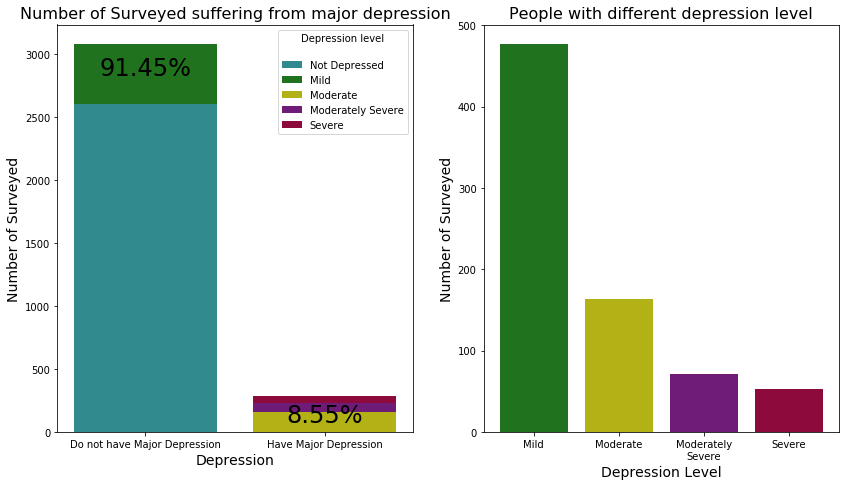

In [35]:
graphic.create_bars_for_depression_groups(depression_groups)

#### During 2015–2026, ~8.55% of Americans aged 17 and over had depression (moderate or severe depressive symptoms in the past 2 weeks). 

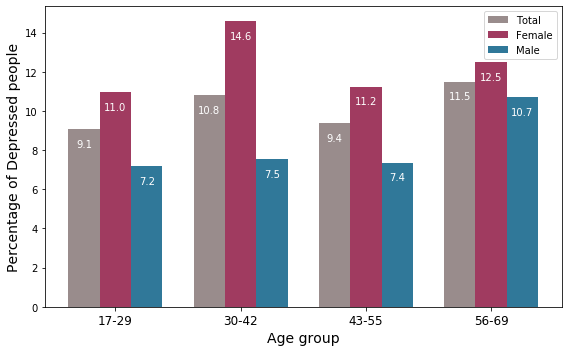

In [36]:
graphic.create_grouped_bars(depr_age, female_age_depr, male_age_depr, bar_width=.25, labels=("Total", "Female", "Male"), xlabel="Age group", ylabel="Percentage of Depressed people")

* **Males have significantly lower rates than females overall and in every age group.**
* **The highest rate of depression, 14.6%, was found in women aged 30-42.**
* **Depression was more prevalent among females and persons aged 56-69.** 

---
NOTES: Depression is defined as having moderate to severe depressive symptoms. \
SOURCE: CDC/NCHS, National Health and Nutrition Examination Survey.

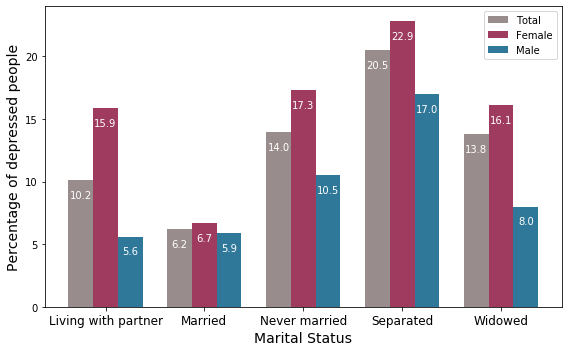

In [37]:
graphic.create_grouped_bars(marital_total, marital_female, marital_male, bar_width=0.25, xlabel="Marital Status", ylabel="Percentage of depressed people")

* **Males have significantly lower rates than females overall and in every Marital status group.**
* **Significant difference occurred between females and males Living with partner.**
* **Major Depression was more prevalent among females and Separated persons.**
* **Major Depression was less prevailed among married people.**
* **The most prevalent group of depressed people, 22.9%, is separated females.**
---
NOTES: Depression is defined as having moderate to severe depressive symptoms.  \
SOURCE: CDC/NCHS, National Health and Nutrition Examination Survey.

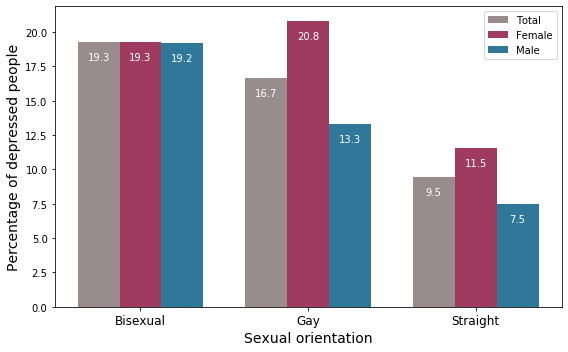

In [38]:
graphic.create_grouped_bars(sex_orientation_total, sex_orientation_female, sex_orientation_male, bar_width=0.25, xlabel="Sexual orientation", ylabel="Percentage of depressed people")

* **Straight people have significantly lower rates than Bisexuals and gays among either males or females and overall.**
* **Significant difference occurred between females and males living with partner.**
* **Major Depression was more prevalent among Bisexual people.**
* **Major Depression was less prevalent among Straight people**
* **Major Depression was equally rated among bisexual females and males.**
---
NOTES: Depression is defined as having moderate to severe depressive symptoms. Sexual orientation is categorized as a result of female orientation and male orientation categories: Gay (Gay or Lesbian for females and Gay for males), Bisexual (Bisexual for both females and males), Straight (Straight for both females and males)  \
SOURCE: CDC/NCHS, National Health and Nutrition Examination Survey.

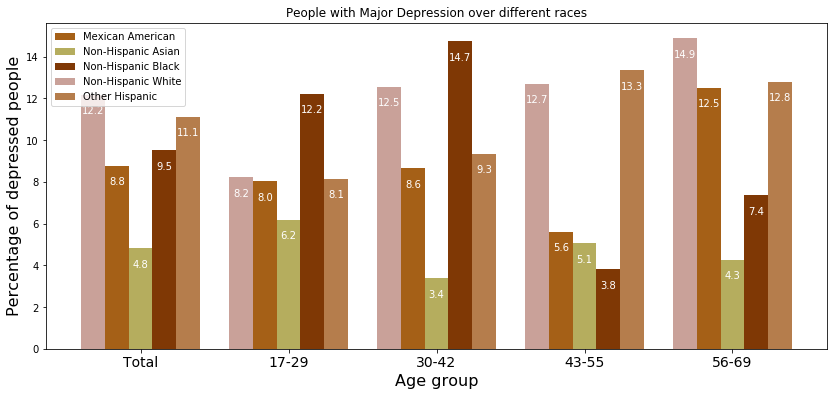

In [39]:
graphic.create_race_bars(races_age, races)

* **Non-Hispanic White and Other Hispanic groups have significantly greater rates than others.**
* **The lowest rates occurred over Non-Hispanic Asian race.**
* **Significant difference occurred over Non-Hispanic Black betwen 30-42 and 43-55.**
---
NOTES: Depression is defined as having moderate to severe depressive symptoms. \
SOURCE: CDC/NCHS, National Health and Nutrition Examination Survey.

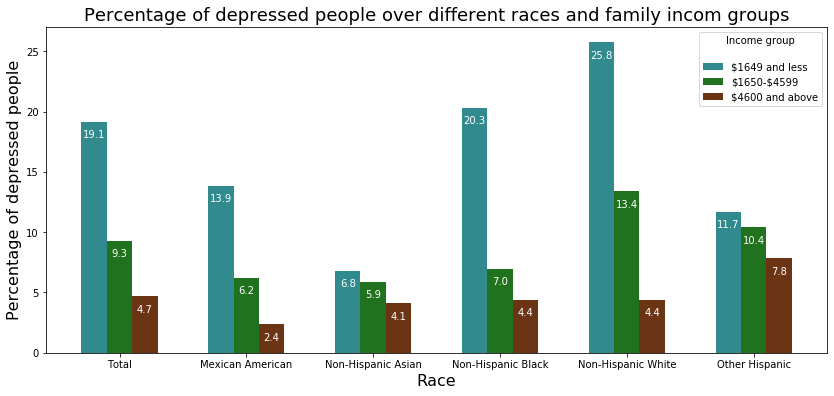

In [40]:
graphic.create_income_bars(income_race, income_total)

* **Representatives with high level of Monthly income showed the lowest rates of Major Depression overall and among different races, as opposed to persons with low level of Monthly income.**
* **Significant difference occurred over different Income group in Non-Hispanic White race.**
---
NOTES: Depression is defined as having moderate to severe depressive symptoms.  \
SOURCE: CDC/NCHS, National Health and Nutrition Examination Survey.

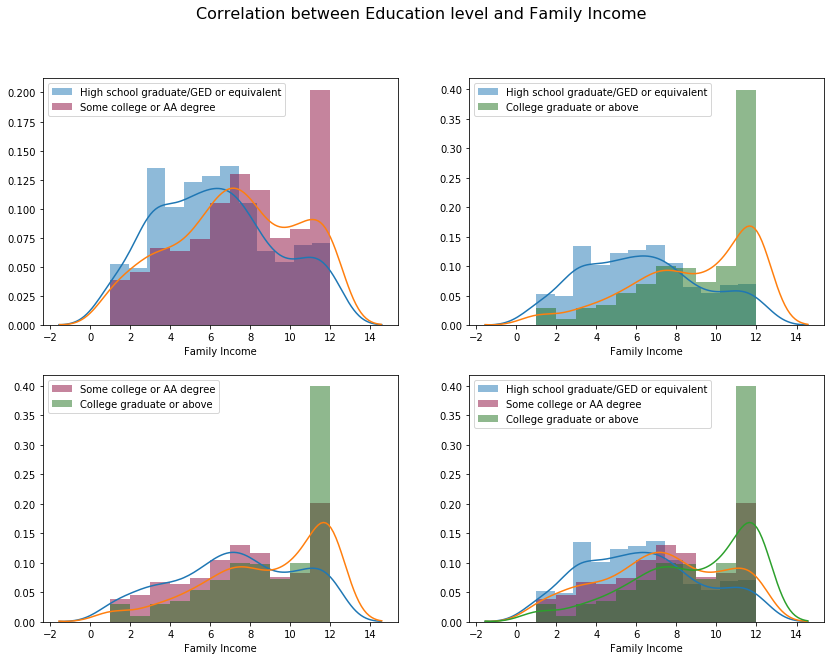

In [41]:
graphic.create_edu_distplots(high_school_ed, college_ed, univers_ed)

#### During the analysis significant correlation occurred between Depression Score and level of Education. However including Education code as a feature in predictive model raised mean absolute error, thus correlation between Education level and Depression Score is accepted as consequence of impact of level of Family Income on Depression Score due to the fact that Education level affects monthly Family Income Index.

* **Representatives with high level of Education showed the highest rates of Monthly Family Income as opposed to persons with low level of Education prevailing on rates of lowest Family Income.**


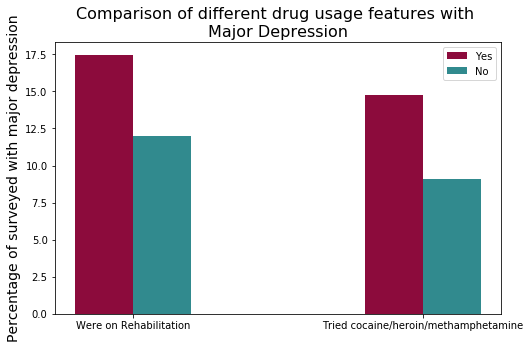

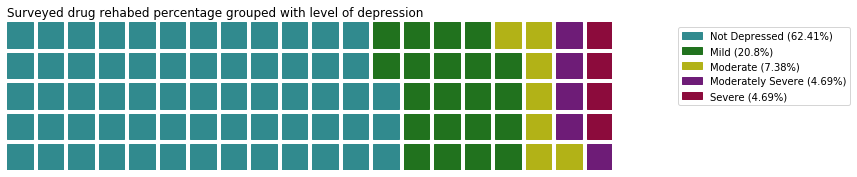

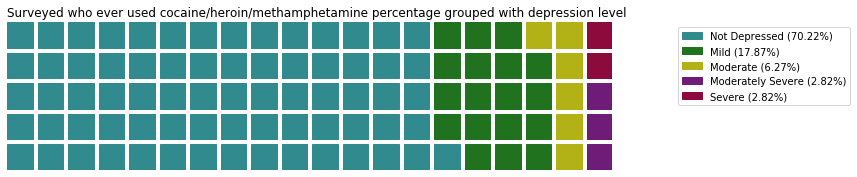

In [42]:
graphic.create_drugs_bars(rehab_2_perc, tried_drugs_2_perc)
graphic.create_drugs_waffles(rehab, rehab_perc, tried_drugs_perc)

* **People who were on rehabilitation program and who tried cocaine/methamphetamine/heroin had significant higher rates of Major Depression.**

---
NOTES: Depression is defined as having moderate to severe depressive symptoms. \
SOURCE: CDC/NCHS, National Health and Nutrition Examination Survey.

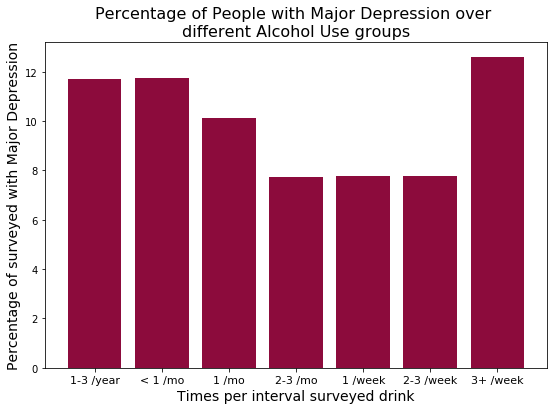

In [43]:
graphic.create_alco_bars(alco_depression_crosstable_perc)

* **Major depression rate remains stable over people who drink alcohol 1-3 times per month, 1 time per week and 2-3 times per week.**
* **Persons drinking 3 and more times per week occurred the most prevailed rate of depression among different alcohol consuming groups accounting for more than 12%.**
* **The second prevailed rate of depression occurred in groups consuming alcohol less than 1 time per month accounting for roughly 12%.** 

---
NOTES: Depression is defined as having moderate to severe depressive symptoms. \
SOURCE: CDC/NCHS, National Health and Nutrition Examination Survey.

# Predictive Analytics

## Data preparation for prediction:

In [44]:
prediction_df = df.copy()

#### Map categorical features back to numerical values:

In [45]:
RACE_MAP_BACK = {"Mexican American":1, "Other Hispanic":2, "Non-Hispanic White":3,"Non-Hispanic Black":4, "Non-Hispanic Asian":6, "Other Race - Including Multi-Racial":7}
MARITAL_MAP_BACK = {"Married":1, "Widowed":2, "Divorced":3, "Separated":4, "Never married":5, "Living with partner":6}
ORIENTATION_MAP_BACK = {"Straight":1, "Gay":2, "Bisexual":3}

prediction_df[RACE] = prediction_df[RACE].map(RACE_MAP_BACK)
prediction_df[MARITAL_STATUS] = prediction_df[MARITAL_STATUS].map(MARITAL_MAP_BACK)
prediction_df[ORIENTATION_BOTH] = prediction_df[ORIENTATION_BOTH].map(ORIENTATION_MAP_BACK)

#### Clean up all non-necessary instances (the ones with missing data):

In [46]:
prediction_df = prediction_df[
    (prediction_df[POVERTY_LEVEL_CATEGORY] != -1111) & 
    (prediction_df[MARITAL_STATUS].isna() == False) & 
    (prediction_df[ORIENTATION_BOTH].isna() == False)
]

#### Select predictive features:

In [47]:
FEATURES = [ORIENTATION_BOTH, POVERTY_LEVEL_CATEGORY, ALCOHOL_USE_GROUP, *DRUG_USE_CODES, *DEMOGRAPHIC_CODES]

### Prediction

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

#### Separate prediction target from features

In [49]:
y = prediction_df[DEPRESSION_SCORE] # We are going to predict Depression score, right!
X = prediction_df[FEATURES]

#### Separate data on 2 subsets:
1. Training set
2. Value set for model validation

In [50]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0)

#### Fit Random Forest model to training values

In [51]:
forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(train_X, train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

#### Predict values to non-training data

In [52]:
prediction = forest_model.predict(val_X)

#### Output mean absoulute error

In [53]:
mean_absolute_error(val_y, prediction)

3.166549003769521